# ASL sign classification

## Importing of libraries

In [186]:
import torch
import os
import random
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

torch.manual_seed(42)

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50,ResNet50_Weights
from torchvision import transforms
import torchvision
from torchvision.datasets import ImageFolder

In [2]:
torch.__version__

'2.0.1+cu117'

In [86]:
TRAIN_DIR = './sign_language/asl_alphabet_train'
VAL_DIR = './sign_language/asl_alphabet_val'
TEST_DIR = './sign_language/asl_alphabet_test'

In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [88]:
labels = os.listdir(TRAIN_DIR)

In [169]:
# generate a list of all files in the list
img_list = list()

for root, dirname, files in os.walk('./sign_language/asl_alphabet_train/'):
    for file in files:
        if file.endswith(".jpg"):
            img_list.append((os.path.join(root, file)))

In [90]:
# Transforms to prepare data for training
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(size=(224,224)),
    transforms.RandomAutocontrast(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
])

In [91]:
train_data = ImageFolder(root=TRAIN_DIR,
                                  transform=data_transform)

test_data = ImageFolder(root=TEST_DIR,
                              transform=data_transform)
val_data = ImageFolder(root=VAL_DIR,
                              transform=data_transform)

In [93]:
print(f"Train data: {train_data}\n Test data: {test_data}\n Valid data: {val_data}")

Train data: Dataset ImageFolder
    Number of datapoints: 86884
    Root location: ./sign_language/asl_alphabet_train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomAutocontrast(p=0.6)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
 Test data: Dataset ImageFolder
    Number of datapoints: 116
    Root location: ./sign_language/asl_alphabet_test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomAutocontrast(p=0.6)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
 Valid data: Dataset ImageFolder
    Number of datapoints: 29
    Root location: ./sign_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Before and after transform')

<Figure size 2400x800 with 0 Axes>

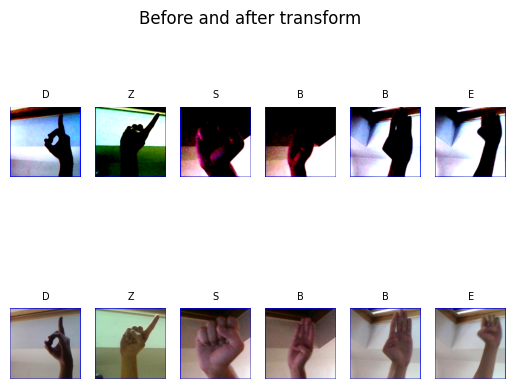

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


#choose random images from list
random_samples_idx = random.sample(range(len(train_data)), k=6)


plt.figure(figsize=(24, 8))
fig,ax = plt.subplots(2,6)


for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = train_data[targ_sample][0], train_data[targ_sample][1]
    
    # Convert CHW to HWC
    targ_image_adjust = targ_image.permute(1, 2, 0)

        
    ax[0,i].imshow(targ_image_adjust)
    ax[0,i].axis("off")
    title = f"{train_data.classes[targ_label]}"
    ax[0,i].set_title(title, fontsize = 7)
    
    trans_img = (targ_image_adjust.numpy() * std + mean).clip(0,1)
    ax[1,i].imshow(trans_img)
    ax[1,i].axis("off")
    ax[1,i].set_title(f"{title}",fontsize = 7)
    
fig.suptitle("Before and after transform")

In [94]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=32)
test_loader = DataLoader(test_data,shuffle=False,batch_size=8)
valid_loader = DataLoader(val_data,shuffle=False,batch_size=1)

## Creating Model

In [39]:
weights = ResNet50_Weights.IMAGENET1K_V2

In [40]:
resnet = resnet50(weights=weights)

In [41]:
# This is used to remove Training the full layers
for param in resnet.parameters():
    param.requires_grad = False

In [42]:
resnet.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 29), 
    nn.LogSoftmax(dim=1)
    )

In [43]:
# summary of the model
summary(resnet,input_size = [32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 29]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [51]:
resnet.to(device)
# loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer for weight adjustment
optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.001)

## Training and Testing loop

In [52]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward Tracking(autograd)
        loss.backward()

        # Optimizer step(making changes to the weigths)
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [53]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager this remove grad
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [56]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 20):
    
    #Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # Print Results after each epoch
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

## Training the Resnet

In [60]:
# Set number of epochs
NUM_EPOCHS = 50

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results = train(model=resnet, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and duration of training
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|█▌                                                                             | 1/50 [13:02<10:39:20, 782.88s/it]

Epoch: 1 | train_loss: 0.5499 | train_acc: 0.8357 | test_loss: 0.2034 | test_acc: 0.9583



  4%|███▏                                                                            | 2/50 [20:33<7:49:47, 587.24s/it]

Epoch: 2 | train_loss: 0.2059 | train_acc: 0.9314 | test_loss: 0.0815 | test_acc: 0.9750



  6%|████▊                                                                           | 3/50 [28:03<6:50:56, 524.60s/it]

Epoch: 3 | train_loss: 0.1704 | train_acc: 0.9416 | test_loss: 0.0388 | test_acc: 0.9833



  8%|██████▍                                                                         | 4/50 [35:31<6:19:06, 494.49s/it]

Epoch: 4 | train_loss: 0.1497 | train_acc: 0.9490 | test_loss: 0.0972 | test_acc: 0.9667



 10%|████████                                                                        | 5/50 [43:00<5:58:38, 478.19s/it]

Epoch: 5 | train_loss: 0.1346 | train_acc: 0.9540 | test_loss: 0.0841 | test_acc: 0.9583



 12%|█████████▌                                                                      | 6/50 [50:30<5:43:31, 468.45s/it]

Epoch: 6 | train_loss: 0.1297 | train_acc: 0.9560 | test_loss: 0.0871 | test_acc: 0.9833



 14%|███████████▏                                                                    | 7/50 [57:59<5:31:07, 462.04s/it]

Epoch: 7 | train_loss: 0.1223 | train_acc: 0.9584 | test_loss: 0.0380 | test_acc: 0.9833



 16%|████████████▍                                                                 | 8/50 [1:05:28<5:20:34, 457.96s/it]

Epoch: 8 | train_loss: 0.1096 | train_acc: 0.9632 | test_loss: 0.0140 | test_acc: 1.0000



 18%|██████████████                                                                | 9/50 [1:12:58<5:11:19, 455.60s/it]

Epoch: 9 | train_loss: 0.1104 | train_acc: 0.9631 | test_loss: 0.0190 | test_acc: 0.9917



 20%|███████████████▍                                                             | 10/50 [1:20:28<5:02:36, 453.91s/it]

Epoch: 10 | train_loss: 0.1099 | train_acc: 0.9641 | test_loss: 0.0352 | test_acc: 0.9917



 22%|████████████████▉                                                            | 11/50 [1:27:57<4:53:56, 452.23s/it]

Epoch: 11 | train_loss: 0.1005 | train_acc: 0.9664 | test_loss: 0.0722 | test_acc: 0.9750



 24%|██████████████████▍                                                          | 12/50 [1:35:25<4:45:39, 451.04s/it]

Epoch: 12 | train_loss: 0.1003 | train_acc: 0.9673 | test_loss: 0.0569 | test_acc: 0.9833



 26%|████████████████████                                                         | 13/50 [1:42:54<4:37:40, 450.28s/it]

Epoch: 13 | train_loss: 0.0965 | train_acc: 0.9685 | test_loss: 0.1126 | test_acc: 0.9667



 28%|█████████████████████▌                                                       | 14/50 [1:50:22<4:29:51, 449.76s/it]

Epoch: 14 | train_loss: 0.0948 | train_acc: 0.9694 | test_loss: 0.0644 | test_acc: 0.9917



 30%|███████████████████████                                                      | 15/50 [1:57:51<4:22:11, 449.46s/it]

Epoch: 15 | train_loss: 0.0953 | train_acc: 0.9689 | test_loss: 0.0397 | test_acc: 0.9917



 32%|████████████████████████▋                                                    | 16/50 [2:05:20<4:14:32, 449.18s/it]

Epoch: 16 | train_loss: 0.0929 | train_acc: 0.9702 | test_loss: 0.0038 | test_acc: 1.0000



 34%|██████████████████████████▏                                                  | 17/50 [2:12:49<4:07:08, 449.34s/it]

Epoch: 17 | train_loss: 0.0898 | train_acc: 0.9709 | test_loss: 0.0242 | test_acc: 0.9917



 36%|███████████████████████████▋                                                 | 18/50 [2:20:20<3:59:49, 449.67s/it]

Epoch: 18 | train_loss: 0.0865 | train_acc: 0.9728 | test_loss: 0.0017 | test_acc: 1.0000



 38%|█████████████████████████████▎                                               | 19/50 [2:27:49<3:52:14, 449.49s/it]

Epoch: 19 | train_loss: 0.0826 | train_acc: 0.9734 | test_loss: 0.0711 | test_acc: 0.9750



 40%|██████████████████████████████▊                                              | 20/50 [2:35:17<3:44:35, 449.19s/it]

Epoch: 20 | train_loss: 0.0887 | train_acc: 0.9720 | test_loss: 0.1187 | test_acc: 0.9833



 42%|████████████████████████████████▎                                            | 21/50 [2:42:46<3:37:01, 449.01s/it]

Epoch: 21 | train_loss: 0.0836 | train_acc: 0.9742 | test_loss: 0.1284 | test_acc: 0.9667



 44%|█████████████████████████████████▉                                           | 22/50 [2:50:14<3:29:28, 448.88s/it]

Epoch: 22 | train_loss: 0.0813 | train_acc: 0.9748 | test_loss: 0.0662 | test_acc: 0.9917



 46%|███████████████████████████████████▍                                         | 23/50 [2:57:44<3:22:00, 448.92s/it]

Epoch: 23 | train_loss: 0.0827 | train_acc: 0.9747 | test_loss: 0.0857 | test_acc: 0.9917



 48%|████████████████████████████████████▉                                        | 24/50 [3:05:12<3:14:31, 448.90s/it]

Epoch: 24 | train_loss: 0.0823 | train_acc: 0.9744 | test_loss: 0.0802 | test_acc: 0.9833



 50%|██████████████████████████████████████▌                                      | 25/50 [3:12:41<3:07:03, 448.94s/it]

Epoch: 25 | train_loss: 0.0796 | train_acc: 0.9754 | test_loss: 0.0452 | test_acc: 0.9833



 52%|████████████████████████████████████████                                     | 26/50 [3:20:12<2:59:46, 449.46s/it]

Epoch: 26 | train_loss: 0.0758 | train_acc: 0.9769 | test_loss: 0.0232 | test_acc: 0.9917



 54%|█████████████████████████████████████████▌                                   | 27/50 [3:27:42<2:52:19, 449.54s/it]

Epoch: 27 | train_loss: 0.0789 | train_acc: 0.9760 | test_loss: 0.0660 | test_acc: 0.9833



 56%|███████████████████████████████████████████                                  | 28/50 [3:35:11<2:44:45, 449.36s/it]

Epoch: 28 | train_loss: 0.0785 | train_acc: 0.9767 | test_loss: 0.0280 | test_acc: 0.9833



 58%|████████████████████████████████████████████▋                                | 29/50 [3:42:39<2:37:12, 449.17s/it]

Epoch: 29 | train_loss: 0.0747 | train_acc: 0.9776 | test_loss: 0.1335 | test_acc: 0.9833



 60%|██████████████████████████████████████████████▏                              | 30/50 [3:50:08<2:29:38, 448.93s/it]

Epoch: 30 | train_loss: 0.0770 | train_acc: 0.9770 | test_loss: 0.1295 | test_acc: 0.9750



 62%|███████████████████████████████████████████████▋                             | 31/50 [3:57:36<2:22:08, 448.84s/it]

Epoch: 31 | train_loss: 0.0755 | train_acc: 0.9775 | test_loss: 0.0703 | test_acc: 0.9833



 64%|█████████████████████████████████████████████████▎                           | 32/50 [4:05:05<2:14:37, 448.77s/it]

Epoch: 32 | train_loss: 0.0762 | train_acc: 0.9777 | test_loss: 0.0385 | test_acc: 0.9917



 66%|██████████████████████████████████████████████████▊                          | 33/50 [4:12:33<2:07:07, 448.65s/it]

Epoch: 33 | train_loss: 0.0764 | train_acc: 0.9782 | test_loss: 0.0788 | test_acc: 0.9833



 68%|████████████████████████████████████████████████████▎                        | 34/50 [4:20:03<1:59:44, 449.01s/it]

Epoch: 34 | train_loss: 0.0760 | train_acc: 0.9781 | test_loss: 0.0110 | test_acc: 1.0000



 70%|█████████████████████████████████████████████████████▉                       | 35/50 [4:27:33<1:52:18, 449.23s/it]

Epoch: 35 | train_loss: 0.0718 | train_acc: 0.9787 | test_loss: 0.0014 | test_acc: 1.0000



 72%|███████████████████████████████████████████████████████▍                     | 36/50 [4:35:03<1:44:50, 449.32s/it]

Epoch: 36 | train_loss: 0.0690 | train_acc: 0.9793 | test_loss: 0.0817 | test_acc: 0.9917



 74%|████████████████████████████████████████████████████████▉                    | 37/50 [4:42:31<1:37:19, 449.19s/it]

Epoch: 37 | train_loss: 0.0717 | train_acc: 0.9796 | test_loss: 0.0227 | test_acc: 0.9917



 76%|██████████████████████████████████████████████████████████▌                  | 38/50 [4:50:00<1:29:48, 449.05s/it]

Epoch: 38 | train_loss: 0.0735 | train_acc: 0.9793 | test_loss: 0.0006 | test_acc: 1.0000



 78%|████████████████████████████████████████████████████████████                 | 39/50 [4:57:29<1:22:19, 449.02s/it]

Epoch: 39 | train_loss: 0.0746 | train_acc: 0.9792 | test_loss: 0.0545 | test_acc: 0.9917



 80%|█████████████████████████████████████████████████████████████▌               | 40/50 [5:04:58<1:14:49, 448.97s/it]

Epoch: 40 | train_loss: 0.0722 | train_acc: 0.9796 | test_loss: 0.1102 | test_acc: 0.9583



 82%|███████████████████████████████████████████████████████████████▏             | 41/50 [5:12:27<1:07:19, 448.88s/it]

Epoch: 41 | train_loss: 0.0753 | train_acc: 0.9790 | test_loss: 0.0090 | test_acc: 0.9917



 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [5:19:56<59:51, 448.99s/it]

Epoch: 42 | train_loss: 0.0697 | train_acc: 0.9799 | test_loss: 0.0125 | test_acc: 0.9917



 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [5:27:26<52:24, 449.20s/it]

Epoch: 43 | train_loss: 0.0702 | train_acc: 0.9808 | test_loss: 0.0514 | test_acc: 0.9917



 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [5:34:56<44:56, 449.43s/it]

Epoch: 44 | train_loss: 0.0721 | train_acc: 0.9803 | test_loss: 0.0451 | test_acc: 0.9917



 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [5:42:25<37:27, 449.43s/it]

Epoch: 45 | train_loss: 0.0658 | train_acc: 0.9818 | test_loss: 0.0117 | test_acc: 0.9917



 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [5:49:54<29:56, 449.19s/it]

Epoch: 46 | train_loss: 0.0687 | train_acc: 0.9806 | test_loss: 0.0385 | test_acc: 0.9917



 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [5:57:22<22:27, 449.04s/it]

Epoch: 47 | train_loss: 0.0681 | train_acc: 0.9815 | test_loss: 0.0562 | test_acc: 0.9917



 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [6:04:51<14:57, 448.89s/it]

Epoch: 48 | train_loss: 0.0680 | train_acc: 0.9815 | test_loss: 0.0366 | test_acc: 0.9917



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [6:12:19<07:28, 448.71s/it]

Epoch: 49 | train_loss: 0.0663 | train_acc: 0.9820 | test_loss: 0.0663 | test_acc: 0.9917


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [6:19:48<00:00, 455.77s/it]

Epoch: 50 | train_loss: 0.0700 | train_acc: 0.9810 | test_loss: 0.0082 | test_acc: 0.9917
Total training time: 22788.320 seconds


In [63]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [72]:
def plot_loss_curves(result):
    
    # Getting variables from dict
    train_loss = result['train_loss']
    test_loss = result['test_loss']
    
    train_acc = result['train_acc']
    test_acc = result['test_acc']
    
    epoch = range(len(train_acc))
    
    plt.figure(figsize=(15,7))
    
    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epoch, train_loss, label='Train_loss')
    plt.plot(epoch, test_loss, label='Test_loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    
    # Accuarcy Plot
    plt.subplot(1,2,2)
    plt.plot(epoch, train_acc, label='Train_accuracy')
    plt.plot(epoch, test_acc, label='Test accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy')

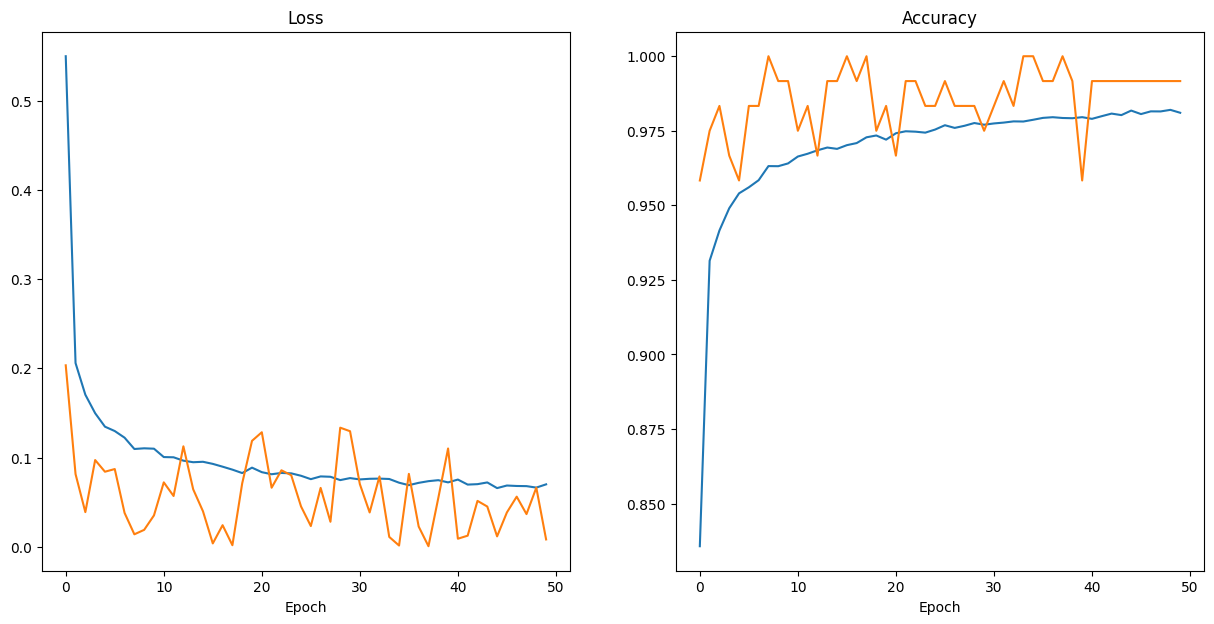

In [73]:
plot_loss_curves(model_results)

## Accuracy of model

In [111]:
# used to Find accuracy of model
def accuracy_of_model(model,loader,loss_fn):
    # Put model in eval mode
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.inference_mode():
        for batch,(data,target) in enumerate(loader):
            data,target = data.to(device),target.to(device)

            # make prediction
            pred = model(data)
            
            # calculate loss
            loss = loss_fn(pred,target)
            val_loss = loss.item()
            
            # calculate accuracy
            pred_label = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            val_acc += ((pred_label == target).sum().item()/len(pred_label))
    val_loss = val_loss / len(loader)
    val_acc = val_acc / len(loader)
    return val_acc,val_loss

In [112]:
accuracy,loss = accuracy_of_model(resnet,valid_loader,loss_fn)

In [114]:
print(f'Accuracy of Resnet model(validation): {accuracy*100}')
print(f'Loss of Resnt model(validation): {loss}')

Accuracy of Resnet model(validation): 100.0
Loss of Resnt model(validation): 0.0


In [123]:
custom_image_path = os.path.join(VAL_DIR,'A/A_test.jpg')

custom_image = data_transform((Image.open(custom_image_path)))

In [124]:
resnet.eval()
with torch.inference_mode():
    logits = resnet(custom_image.unsqueeze(dim=0).to(device))
    
    pred_label = torch.argmax(torch.softmax(logits,dim=1),dim=1)

In [125]:
classes = train_data.classes

In [126]:
print(f'Predicted class: {classes[pred_label.cpu()]}')

Predicted class: A


Text(0.5, 1.0, 'Predicted: A |Probability: 100.0')

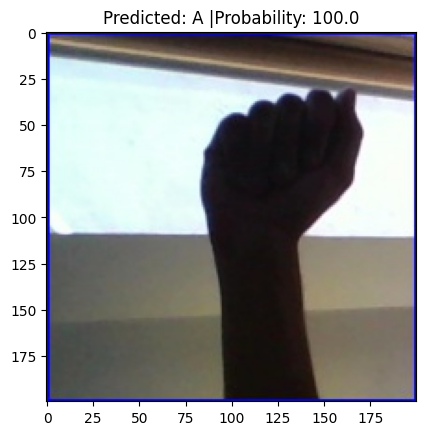

In [175]:
plt.imshow(Image.open(custom_image_path))
plt.title(f'Predicted: {classes[pred_label]} |Probability: {torch.softmax(logits,dim=1).max().cpu()*100}')

In [150]:
valid_img_list = list()

for root, dirname, files in os.walk('./sign_language/asl_alphabet_val'):
    for file in files:
        if file.endswith(".jpg"):
            valid_img_list.append((os.path.join(root, file)))

## Random Prediction and Probabilities

Text(0, 0.5, 'Classes')

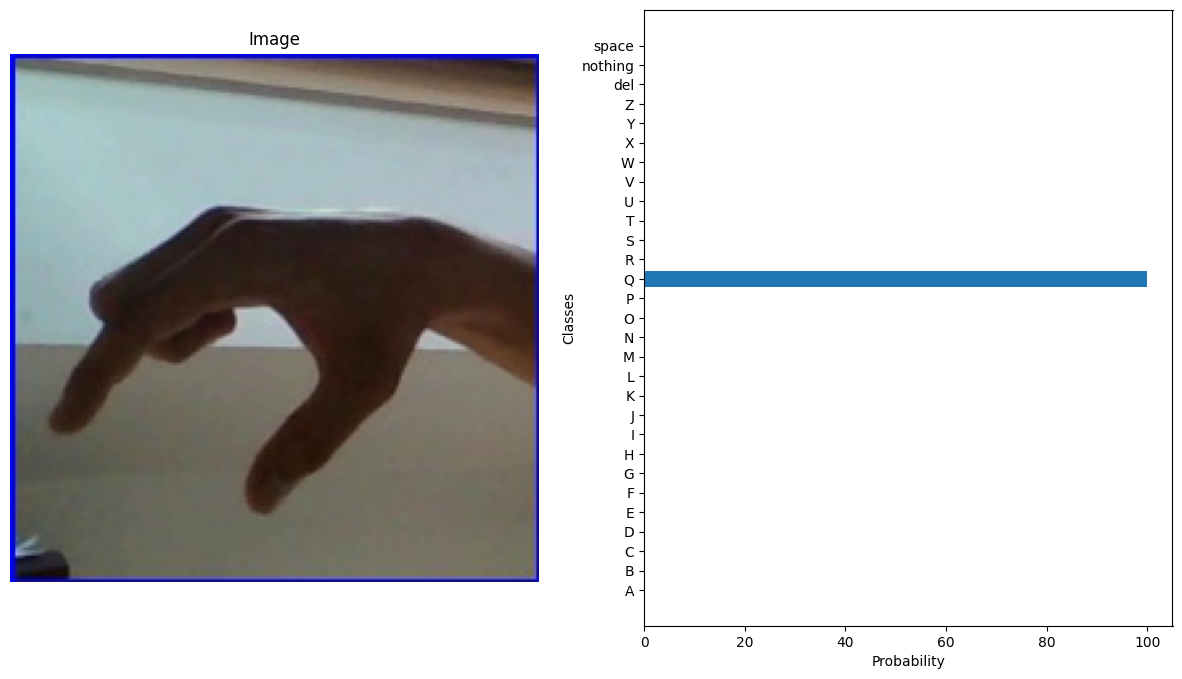

In [168]:
random_path = random.choice(valid_img_list)
random_image = data_transform((Image.open(random_path)))

resnet.eval()
with torch.inference_mode():
    output = resnet(random_image.unsqueeze(dim=0).to(device))
    
    label_pred = torch.softmax(output,dim=1)

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(Image.open(random_path))
plt.title('Image')
plt.axis(False)

plt.subplot(1,2,2)
plt.barh(classes,label_pred.cpu().detach().numpy()[0] * 100)
plt.xlabel('Probability')
plt.ylabel('Classes')

## Save Model

In [176]:
torch.save(resnet.state_dict(),'./BestModel/Resnet50_asl.pth')

## Confusion Matrix

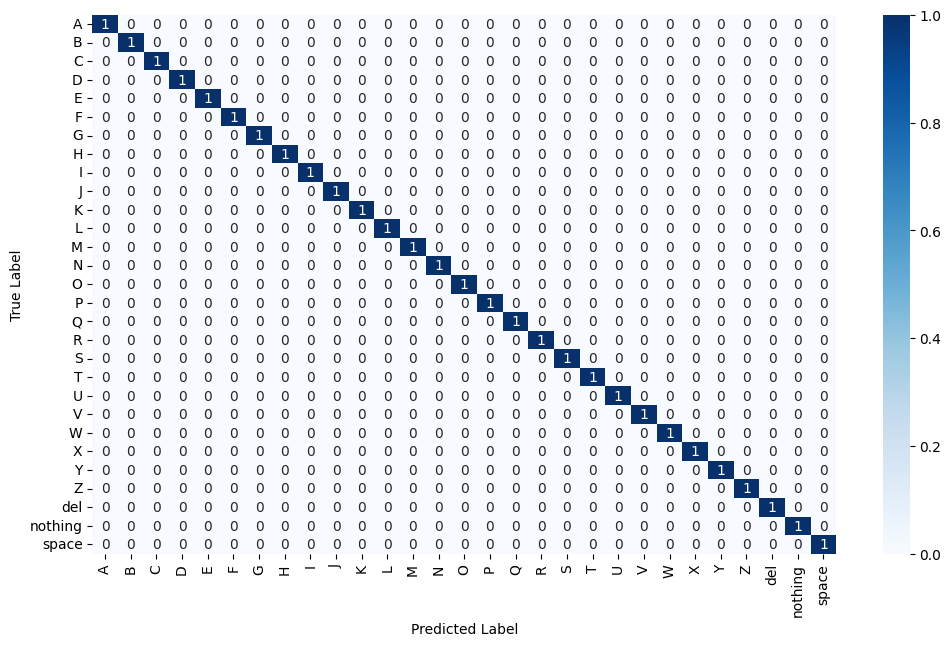

In [189]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

resnet.eval()
# iterate over test data
with torch.inference_mode():
    for batch,(inputs, labels) in enumerate(valid_loader):
        
        inputs, labels = inputs.to(device),labels.to(device)
        output = resnet(inputs) # Feed Network

        output = torch.argmax(output, dim=1).cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True,cmap="Blues")
s.set(xlabel='Predicted Label', ylabel='True Label')
plt.savefig('cmatrixResnet.png')